In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
#plt.style.use('ggplot')
%precision 4
#np.set_printoptions(suppress=True)

'%.4f'

## Interpolation: 

`scipy.interpolate` is useful for fitting a function from experimental data and thus evaluating points where no measure exists. The module is based on the FITPACK Fortran subroutines.

In [2]:
# the actual measurements
measured_time = np.linspace(0, 1, 10)
noise = (np.random.random(10)*2 - 1) * 1e-1
measures = np.sin(2 * np.pi * measured_time) + noise


In [3]:
from scipy.interpolate import interp1d
# linear interpolation
linear_interp = interp1d(measured_time, measures)


The kind of interpolation can be specified: linear is the default;  *zero*, *slinear*, *quadratic* and *cubic* refer to a [spline](https://en.wikipedia.org/wiki/Spline) interpolation of zeroth, first, second or third order; *previous* and *next* simply return the previous or next value of the point.

In [4]:
# cubic interpolation
cubic_interp = interp1d(measured_time, measures, kind='cubic')

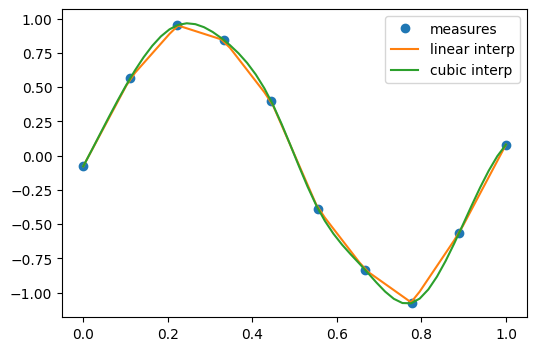

In [5]:
# denser interval to plot the interpolating function
interpolation_time = np.linspace(0, 1, 50)

plt.figure(figsize=(6, 4))
plt.plot(measured_time, measures, 'o', ms=6, label='measures')

linear_results = linear_interp(interpolation_time)
plt.plot(interpolation_time, linear_results, label='linear interp')

cubic_results = cubic_interp(interpolation_time)
plt.plot(interpolation_time, cubic_results, label='cubic interp')
plt.legend()


In [6]:
# checking the punctual results
x=1/4.
print ("sin(x):",np.sin(2 * np.pi * x), 
       "linear prediction:",linear_interp(x),
       "cubic prediction:", cubic_interp(x))



sin(x): 1.0 linear prediction: 0.9240291192093432 cubic prediction: 0.9657818119074663


# Optimization and fit: `scipy.optimize`

Optimization is the problem of finding a numerical solution to a minimization or equality.

The `scipy.optimize` module provides algorithms for function minimization (scalar or multi-dimensional), curve fitting and root finding.

*scipy is not the best library around for performing such tasks. in fact, scipy essential wrappes old code written in c/ fortran. pytorch and other libraries have better codes. Keep it in mind, but for ordinary tasks scipy is often enough*

In [27]:
from scipy import optimize

## Curve Fitting (=== parameter estimation)

Fitting is the core business of data analysis or in general data science. If you *know* the underlying model, then the overall problem is simple. If you don't, then it is a very delicate issue.

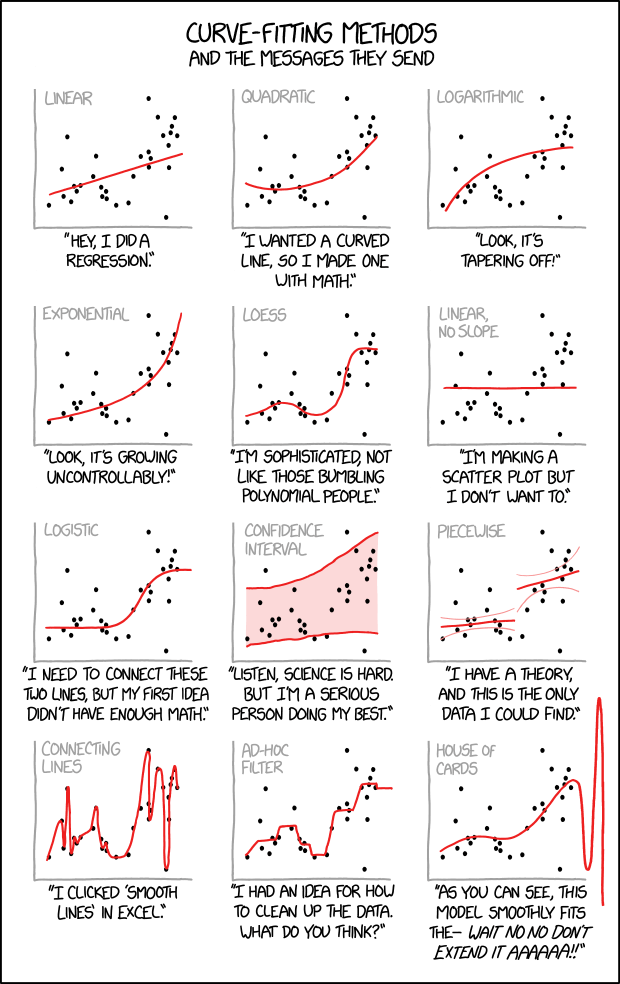

In [8]:
from IPython.display import Image
Image("xkcd_curve_fitting.png")

Let's take some data, sampled from a sine distribution and affected by random noise

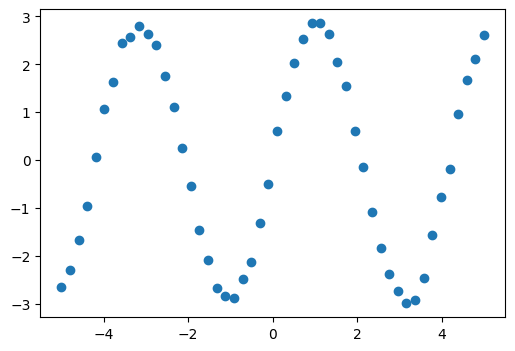

In [34]:
x_data = np.linspace(-5, 5, num=50)
y_data = 2.9 * np.sin(1.5 * x_data) + 0.1 * np.random.normal(size=50)

import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))
plt.scatter(x_data, y_data)

If we *knew* (or better said: your prior for a sine distribution is close to 1) that the data is sampled from a sine function and we just need to find its parameters, in this case amplitude and frequency, we can do that by least squares curve fitting. 

In [35]:
def f(x, A, nu):
    return A * np.sin(nu * x)

*When you do a fit like this, you have a strong prior so you approximately know the values of the parameters. On the other hand, if you draw them at random, there is chance that you will end up in a local minimum and so you will get the wrong result.*


**comment on systematic (or biased) fitting procedures**

*Also, when you do parameter estimation, it is better to try out the whole procedure you intend to follow on simulated data first. This way you can find out if, for example you get a sistematic bias (i.e. estimation systematically lower/higher than true value. If so, you need to change your fitting procedure first, then do the task on the real dataset.*




*For example, if you need to fit the data with a background noise function, you should try out several noise functions expressions and then compare the estimations you get. In fact, you typically know there is noise but you don't know a-priori how does the noise look like.*

In [36]:
# fit by means of curve_fit
# p0 are the guessed values for the parameters
params, params_covariance = optimize.curve_fit(f, x_data, y_data, p0=[2, 2])
print(params)
print (params_covariance)

# get the full output
#optimize.curve_fit(f, x_data, y_data, p0=[2, 2], full_output=True)

[2.8802 1.4992]
[[ 3.6536e-04 -4.4226e-06]
 [-4.4226e-06  4.6827e-06]]


As every fitting problem, this transaltes into a minimization problem: a given function that depends on `f(x_data; params)-y_data` (loss function) is minimized

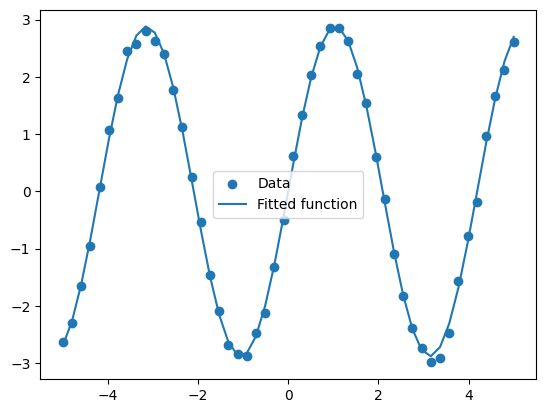

In [37]:
plt.scatter(x_data, y_data, label='Data')
plt.plot(x_data, f(x_data, params[0], params[1]),
         label='Fitted function')

plt.legend(loc='best')

##  Roots of scalar and functions

Several methods are there for $f(x): {\rm I\!R} \to {\rm I\!R}$, e.g. [Newton-Raphson](https://en.wikipedia.org/wiki/Newton%27s_method) or Brent (a safer version of the secant method, which combines a bracketing strategy with a parabolic approximation)

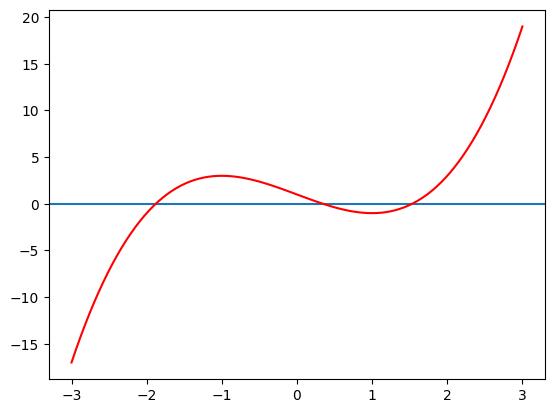

In [13]:
def f(x):
    return x**3-3*x+1

x = np.linspace(-3,3,100)
plt.axhline(0)
plt.plot(x, f(x),'r-');

In [14]:
from scipy.optimize import brentq
brentq(f, -3, 0), brentq(f, 0, 1), brentq(f, 1,3)

(-1.8794, 0.3473, 1.5321)

In [15]:
from scipy.optimize import newton
newton(f, -3), newton(f, 0), newton(f, 3)

(-1.8794, 0.3473, 1.5321)

In case of $f(x): {\rm I\!R}^2 \to {\rm I\!R}$, the `optimize.root` is available, also implementing several methods (MINPACK's hybrd being the default)

In [16]:
from scipy.optimize import root, fsolve

def f(x):
    return [x[1] - 3*x[0]*(x[0]+1)*(x[0]-1),
            .25*x[0]**2 + x[1]**2 - 1]

solutions = root(f, (0.5, 0.5))
print (solutions)

print (f(solutions.x))

 message: The solution converged.
 success: True
  status: 1
     fun: [-1.636e-12  1.619e-12]
       x: [ 1.117e+00  8.295e-01]
  method: hybr
    nfev: 23
    fjac: [[-9.978e-01  6.589e-02]
           [-6.589e-02 -9.978e-01]]
       r: [ 8.229e+00 -8.826e-01 -1.726e+00]
     qtf: [-1.495e-08  1.270e-08]
[np.float64(-1.6360246490876307e-12), np.float64(1.6187051699034782e-12)]


## Minimization of a function

The `minimize_scalar` function will find the minimum, and can also be told to search within given bounds. By default, it uses the Brent algorithm.

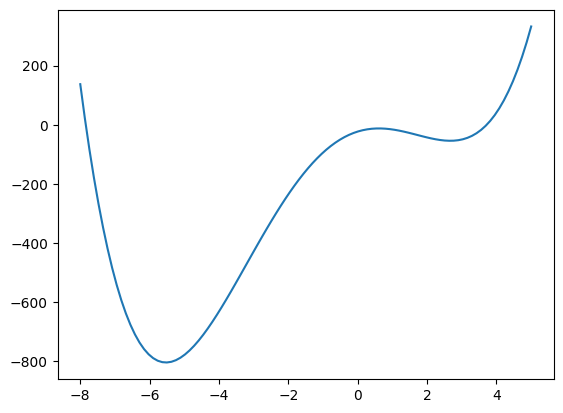

In [17]:
def f(x):
    return x**4 + 3*(x-2)**3 - 15*(x)**2 + 1

x = np.linspace(-8, 5, 100)
plt.plot(x, f(x));

In [18]:
optimize.minimize_scalar(f, method='Brent')


 message: 
          Optimization terminated successfully;
          The returned value satisfies the termination criteria
          (using xtol = 1.48e-08 )
 success: True
     fun: -803.3955308825884
       x: -5.528801125219663
     nit: 11
    nfev: 16

In [19]:
optimize.minimize_scalar(f, method='bounded', bounds=[0, 6])


 message: Solution found.
 success: True
  status: 0
     fun: -54.21003937712762
       x: 2.668865104039653
     nit: 12
    nfev: 12

### Local and global minima

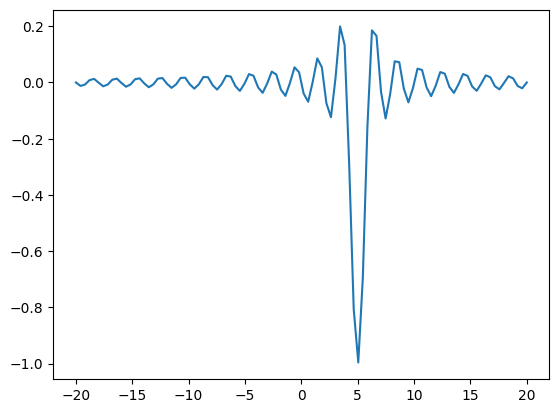

In [20]:
def f(x, offset):
    return -np.sinc(x-offset)

x = np.linspace(-20, 20, 100)
plt.plot(x, f(x, 5));

In [21]:
# note how additional function arguments are passed in
solution = optimize.minimize_scalar(f, args=(5,))
solution

 message: 
          Optimization terminated successfully;
          The returned value satisfies the termination criteria
          (using xtol = 1.48e-08 )
 success: True
     fun: -0.049029624014074166
       x: -1.4843871263953001
     nit: 10
    nfev: 14

Optimization results are packed accordingly to  this [format](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.OptimizeResult.html#scipy.optimize.OptimizeResult)

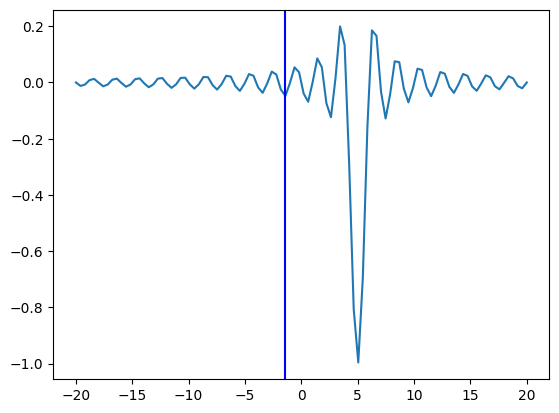

In [22]:
plt.plot(x, f(x, 5))
plt.axvline(solution.x,color='b')

When the function oscillates a lot, often the global minimum is not found. **To cope with that, several ranges needs to be explored and then compared.**

In [23]:
lower = np.random.uniform(-20, 20, 100)
upper = lower + 1
solutions = [optimize.minimize_scalar(f, args=(5,), bracket=(l, u)) for (l, u) in zip(lower, upper)]

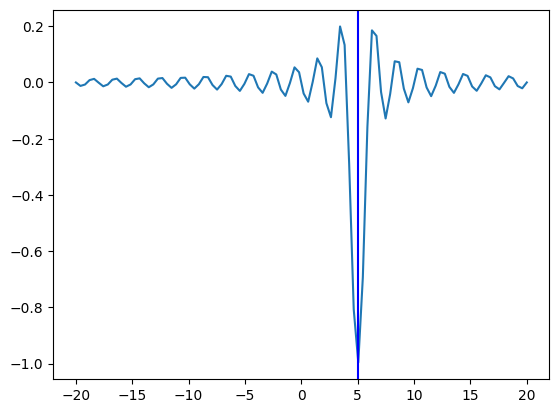

In [24]:
idx = np.argmin([solution.fun for solution in solutions])
solution = solutions[idx]

plt.plot(x, f(x, 5))
plt.axvline(solution.x, color='b');

Alternatively a dedicated method is available

In [25]:
from scipy.optimize import basinhopping

x0 = 0
solution = basinhopping(f, x0, stepsize=1, minimizer_kwargs={'args': (5,)})
solution

                    message: ['requested number of basinhopping iterations completed successfully']
                    success: True
                        fun: -0.9999999999999999
                          x: [ 5.000e+00]
                        nit: 100
      minimization_failures: 0
                       nfev: 1266
                       njev: 633
 lowest_optimization_result:  message: Optimization terminated successfully.
                              success: True
                               status: 0
                                  fun: -0.9999999999999999
                                    x: [ 5.000e+00]
                                  nit: 4
                                  jac: [ 0.000e+00]
                             hess_inv: [[ 3.040e-01]]
                                 nfev: 12
                                 njev: 6

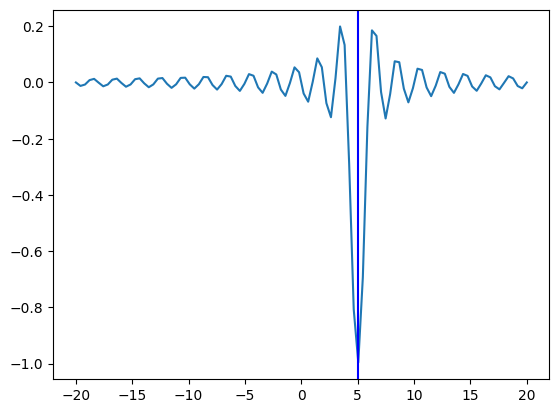

In [26]:
plt.plot(x, f(x, 5))
plt.axvline(solution.x, color='b');

Minimization of f(x): ${\rm I\!R}^n \to {\rm I\!R}$ is a whole field of study per se. You should have seen it treated in details in other courses.

# Statistics and random numbers: `scipy.stats`

*We are going to use scipy as a standard when we want to fit data with a PDF distribution*

The module scipy.stats contains statistical tools and probabilistic descriptions of random processes. Random number generators for various random process can be found in numpy.random.

Given observations of a random process, their histogram is an estimator of the random process’s PDF (probability density function):

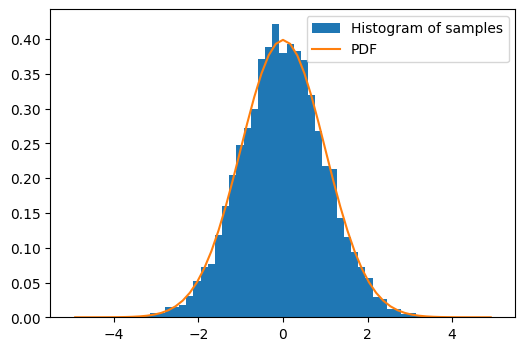

In [41]:
# Sample from a normal distribution using numpy's random number generator
samples = np.random.normal(size=10000)

# Compute a histogram of the sample
bins = np.linspace(-5, 5, 60)

# Compute the PDF on the bin centers from scipy distribution object
from scipy import stats
bin_centers = 0.5*(bins[1:] + bins[:-1])
pdf = stats.norm.pdf(bin_centers)

from matplotlib import pyplot as plt
plt.figure(figsize=(6, 4))
_,_,_ = plt.hist(samples, bins, label="Histogram of samples", density = True) # density = True is for normalization
plt.plot(bin_centers, pdf, label="PDF")
plt.legend()

two ways to normalize: 

1) divide every bin content by the total content: $N_i = N_i/N$
2) specify that the integral is 1: $\sum_i \Delta x_i \cdot N_i = 1$

density = True is doing the 2)

If we know that the random process belongs to a given family of random processes, such as normal processes, we can do a maximum-likelihood fit of the observations to estimate the parameters of the underlying distribution. Here we fit a normal process to the observed data:


In [38]:
mean, std = stats.norm.fit(samples)
print (mean, std)  

NameError: name 'stats' is not defined

## Statistical tests

A statistical test is a decision indicator. For instance, if we have two sets of observations, that we assume are generated from Gaussian processes, we can use a [T-test](https://en.wikipedia.org/wiki/Student%27s_t-test) to decide whether the means of two sets of observations are significantly different:

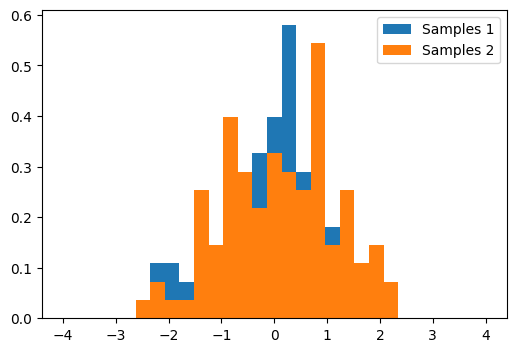

In [42]:
# Generates 2 sets of observations
samples1 = np.random.normal(0, size=100)
samples2 = np.random.normal(0.1, size=100)

# Compute a histogram of the sample
bins = np.linspace(-4, 4, 30)
histogram1, bins = np.histogram(samples1, bins=bins, density=True)
histogram2, bins = np.histogram(samples2, bins=bins, density=True)

plt.figure(figsize=(6, 4))
plt.hist(samples1, bins=bins, density=True, label="Samples 1")
plt.hist(samples2, bins=bins, density=True, label="Samples 2")
plt.legend(loc='best')

In [43]:
stats.ttest_ind(samples1, samples2)

TtestResult(statistic=np.float64(-1.0388909604402836), pvalue=np.float64(0.3001224392329209), df=np.float64(198.0))

In [44]:
np.sum(samples2), np.sum(samples1)

(10.8981, -4.3845)

In [45]:
# most of the test statistics are available 
stats.chisquare(samples1,samples2)

Power_divergenceResult(statistic=np.float64(0.9517877429251664), pvalue=np.float64(1.0))

## Numerical integration: `scipy.integrate`

### Function integrals

The most generic integration routine is `scipy.integrate.quad()`, which integrate from a to b (possibly infinite interval) using a technique from the Fortran library QUADPACK.

 Let's compute $\int_0^{\pi/2} \sin{\theta}d\theta$:


In [47]:
from scipy.integrate import quad, quadrature
res, err = quad(np.sin, 0, np.pi/2)

# An alternative is the gaussian quadrature
#res, err = quadrature(np.sin, 0, np.pi/2)

print (res, err)
print (np.allclose(res, 1))   # res is the result, is should be close to 1

print (np.allclose(err, 1 - res))  

0.9999999999999999 1.1102230246251564e-14
True
True


`scipy.integrate.nquad()` generalize to multiple integration variables

In [ ]:
from scipy.integrate import nquad
func = lambda x0,x1,x2,x3 : x0**2 + x1*x2 - x3**3 + np.sin(x0) + (
                                1 if (x0-.2*x3-.5-.25*x1>0) else 0)
points = [[lambda x1,x2,x3 : 0.2*x3 + 0.5 + 0.25*x1], [], [], []]
def opts0(*args, **kwargs):
    return {'points':[0.2*args[2] + 0.5 + 0.25*args[0]]} 

result, abserr, out = nquad(func, [[0,1], [-1,1], [.13,.8], [-.15,1]], opts=[opts0,{},{},{}], full_output=True)

print (result, abserr)
print (out)

### Integrating differential equations

`scipy.integrate` also features routines for integrating Ordinary Differential Equations (ODE). In particular, `scipy.integrate.odeint()` solves ODE of the form:

```python
dy/dt = rhs(y1, y2, .., t0,...)
```

As an introduction, let us solve the ODE $\frac{dy}{dt} = -2 y$ between $t = 0 \dots 4$, with the initial condition $y(t=0) = 1$. First the function computing the derivative of the position needs to be defined:


In [48]:
def calc_derivative(ypos, time):
    return -2 * ypos

Then, to compute y as a function of time:

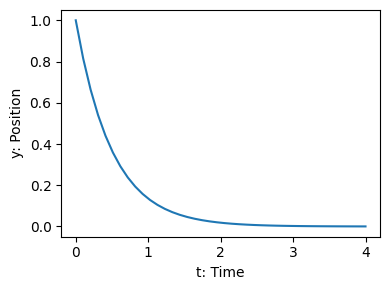

In [49]:
from scipy.integrate import odeint
time_vec = np.linspace(0, 4, 40)
y = odeint(calc_derivative, y0=1, t=time_vec)


plt.figure(figsize=(4, 3))
plt.plot(time_vec, y)
plt.xlabel('t: Time')
plt.ylabel('y: Position')
plt.tight_layout()

It is possible to solve systems of 1st order ODE, like:

$\frac{dx}{dt}=x+y \quad \quad \frac{dy}{dt}=-x+y$

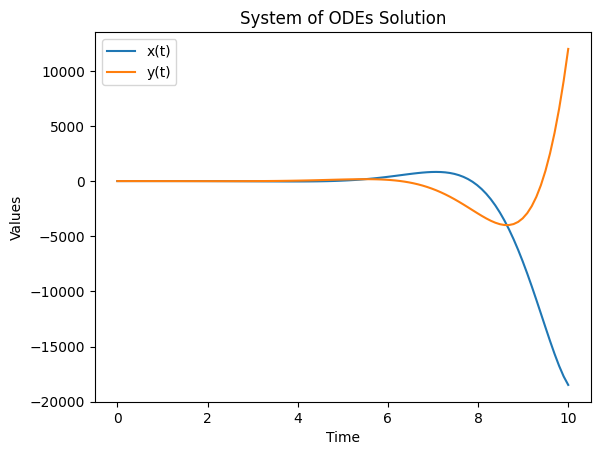

In [50]:
def system(variables, t):
    x, y = variables  # Unpack variables
    dxdt = x + y
    dydt = -x + y
    return [dxdt, dydt]

# Initial conditions
initial_conditions = [1, 0]  # x(0)=1, y(0)=0

# Time points
t = np.linspace(0, 10, 100)

# Solve the system
solution = odeint(system, initial_conditions, t)

# Plot results
plt.plot(t, solution[:, 0], label='x(t)')
plt.plot(t, solution[:, 1], label='y(t)')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.title('System of ODEs Solution')
plt.show()


Let us integrate a more complex ODE: a damped spring-mass oscillator. The position of a mass attached to a spring obeys the 2nd order ODE:

$y'' + 2 \gamma  y' + \omega_0^2 y = 0$ 

with $\omega_0$ the resonant frequency ($\omega_0^2 = k/m$ with $k$ the spring constant, $m$ the mass) and $\gamma$ the damping coefficient.

In order to use `odeint()` to solve that, **the 2nd order equation needs to be transformed in a system of two first-order equations** for the vector $Y = (y, y')$: 

$\frac{dy_1}{dt} = y_2 \quad \quad \frac{dy_2}{dt} = -2\gamma y_2 -\omega_0^2 y_1$

with $y_1 = y$ (the displacement) and $y_2 = \frac{dy}{dt}$ (the velocity). The function to be passed to `odeint` is then:

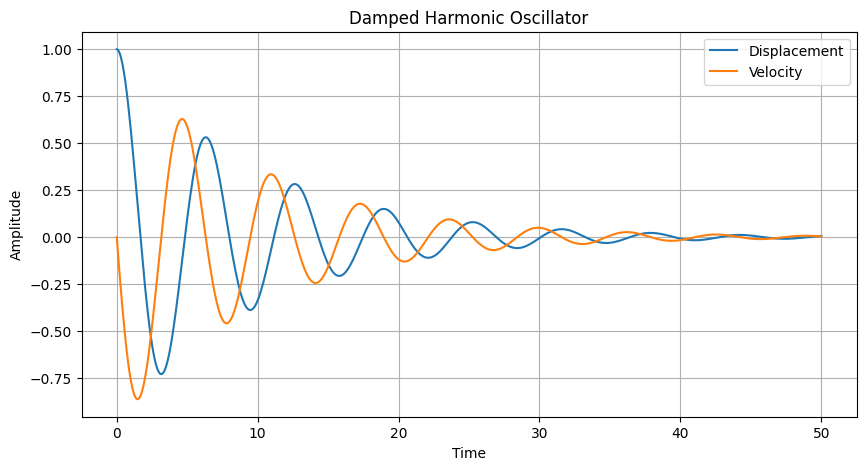

In [51]:
# Define the system of first-order equations
def damped_oscillator(state, t, gamma, omega_0):
    y, v = state  # Unpack the state vector
    dydt = v
    dvdt = -2 * gamma * v - omega_0**2 * y
    return [dydt, dvdt]

# Parameters
gamma = 0.1       # Damping coefficient
omega_0 = 1.0     # Natural frequency
initial_state = [1.0, 0.0]  # Initial conditions: x(0)=1 (displacement), v(0)=0 (velocity)

# Time points to solve the system
t = np.linspace(0, 50, 500)

# Solve the system
solution = odeint(damped_oscillator, initial_state, t, args=(gamma, omega_0))

# Extract displacement (x) and velocity (v) from the solution
y = solution[:, 0]  # Displacement
v = solution[:, 1]  # Velocity

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(t, y, label='Displacement')
plt.plot(t, v, label='Velocity')
plt.title('Damped Harmonic Oscillator')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()
plt.show()


## Symbolic calculations <- NICE !!!


*Find analytical solutions (for problems that admit ones) in Python as you can do in Mathematica!!*

there is also the possibility of performing symbolic calculations (a la Mathematica). `Sympy` is among the most convinent options. Let's solve the damped harmonic oscillation equation 

In [52]:
from sympy import symbols, Function, Eq, dsolve

# Define the symbols
t = symbols('t')  # Time variable
gamma, omega_0 = symbols('gamma omega_0', positive=True, real=True)  # Parameters
x = Function('x')(t)  # Displacement as a function of time

# Define the damped harmonic oscillator equation
damped_eq = Eq(x.diff(t, t) + 2 * gamma * x.diff(t) + omega_0**2 * x, 0)

# Solve the differential equation
solution = dsolve(damped_eq, x)
print("General Solution:")
print(solution)

General Solution:
Eq(x(t), C1*exp(t*(-gamma + sqrt(gamma - omega_0)*sqrt(gamma + omega_0))) + C2*exp(-t*(gamma + sqrt(gamma - omega_0)*sqrt(gamma + omega_0))))


In [53]:
# Define initial conditions: x(0) = 1, x'(0) = 0
ics = {x.subs(t, 0): 1, x.diff(t).subs(t, 0): 0}

# Solve with initial conditions
solution_with_ics = dsolve(damped_eq, x, ics=ics)
print("\nSolution with Initial Conditions:")
print(solution_with_ics)


Solution with Initial Conditions:
Eq(x(t), (-gamma/(2*sqrt(gamma - omega_0)*sqrt(gamma + omega_0)) + 1/2)*exp(-t*(gamma + sqrt(gamma - omega_0)*sqrt(gamma + omega_0))) + (gamma/(2*sqrt(gamma - omega_0)*sqrt(gamma + omega_0)) + 1/2)*exp(t*(-gamma + sqrt(gamma - omega_0)*sqrt(gamma + omega_0))))


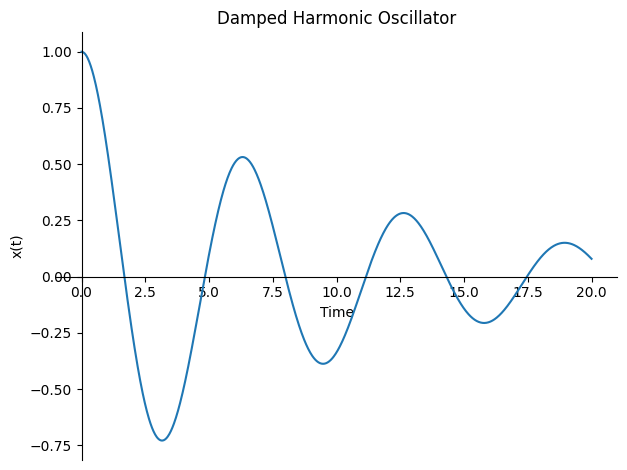

In [54]:
from sympy.plotting import plot
from sympy import sqrt

# Substitute specific values for gamma and omega_0
gamma_val = 0.1
omega_0_val = 1.0
specific_solution = solution_with_ics.subs({gamma: gamma_val, omega_0: omega_0_val})

# Plot the solution
plot(specific_solution.rhs, (t, 0, 20), title="Damped Harmonic Oscillator", ylabel="x(t)", xlabel="Time")


## Fast Fourier Trasform

The `scipy.fftpack` module computes fast Fourier transforms ([FFT](https://en.wikipedia.org/wiki/Fast_Fourier_transform)) and offers utilities to handle them. The main functions are:

* `scipy.fftpack.fft()` to compute the FFT
* `scipy.fftpack.fftfreq()` to generate the sampling frequencies
* `scipy.fftpack.ifft()` computes the inverse FFT, from frequency space to signal space

Let's generate a noisy signal:

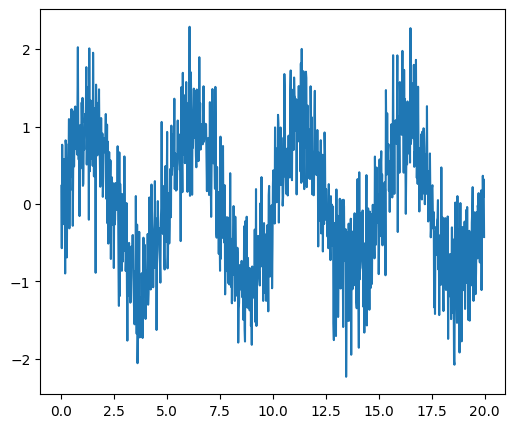

In [55]:
import numpy as np
from scipy import fftpack
from matplotlib import pyplot as plt

# Seed the random number generator
np.random.seed(1234)

time_step = 0.02
period = 5.

time_vec = np.arange(0, 20, time_step)
sig = (np.sin(2 * np.pi / period * time_vec)
       + 0.5 * np.random.randn(time_vec.size))

plt.figure(figsize=(6, 5))
plt.plot(time_vec, sig, label='Original signal')


Let's compute and plot the power spectrum

Is it close to the generated main frequency? True


[]

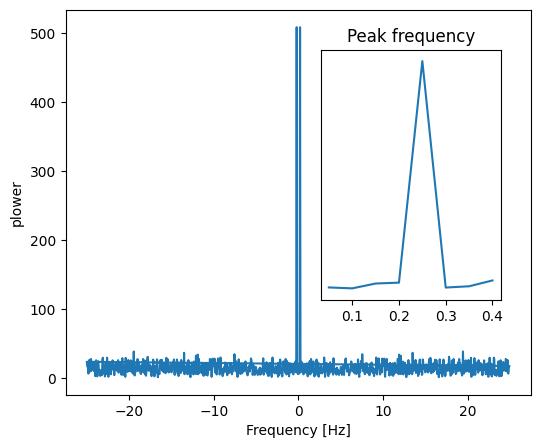

In [56]:
# The FFT of the signal
sig_fft = fftpack.fft(sig)

# And the power (sig_fft is of complex dtype)
power = np.abs(sig_fft)

# The corresponding frequencies
sample_freq = fftpack.fftfreq(sig.size, d=time_step)

# Plot the FFT power
plt.figure(figsize=(6, 5))
plt.plot(sample_freq, power)
plt.xlabel('Frequency [Hz]')
plt.ylabel('plower')

# Find the peak frequency: we can focus on only the positive frequencies
pos_mask = np.where(sample_freq > 0)
freqs = sample_freq[pos_mask]
peak_freq = freqs[power[pos_mask].argmax()]

# Check that it does indeed correspond to the frequency that we generate
# the signal with
print ("Is it close to the generated main frequency?", np.allclose(peak_freq, 1./period))

# An inner plot to show the peak frequency
### NICEEEE ###
axes = plt.axes([0.55, 0.3, 0.3, 0.5])
plt.title('Peak frequency')
plt.plot(freqs[:8], power[:8])
plt.setp(axes, yticks=[])

# scipy.signal.find_peaks_cwt can also be used for more advanced
# peak detection

/Users/miriamzara/LaboratoryOfComputationalPhysics_Y7/myenv/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/miriamzara/LaboratoryOfComputationalPhysics_Y7/myenv/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


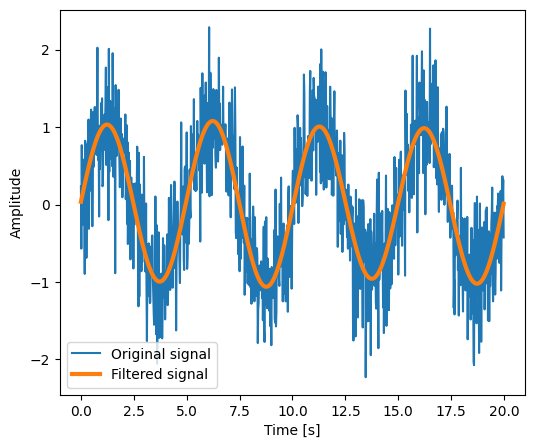

In [57]:
high_freq_fft = sig_fft.copy()
high_freq_fft[np.abs(sample_freq) > peak_freq] = 0
filtered_sig = fftpack.ifft(high_freq_fft)

plt.figure(figsize=(6, 5))
plt.plot(time_vec, sig, label='Original signal')
plt.plot(time_vec, filtered_sig, linewidth=3, label='Filtered signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')

plt.legend(loc='best')
